In [1]:
from dedalus_sphere import jacobi as Jacobi

import numpy as np
import scipy as sp
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=2,suppress=True)

# Add '../' to path
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import spherinder as sph
from spherinder import psi, expand, plotfield


### The Orthogonal Basis
$$ \psi_{m,l,k}(s,\phi,\eta) = e^{i m \phi} P_l(\eta) s^m (1-s^2)^\frac{l}{2} P_k^{l+\frac{1}{2},m}(2s^2 -1)$$

In [2]:
ns, neta = 500, 501
s, eta = np.linspace(0,1,ns), np.linspace(-1,1,neta)

g_disable_basis_plots = True

In [3]:
def plot_basis(basis, s, eta):
    Nmax = len(basis)
    ncols = 3
    nrows = (Nmax+ncols-1)//ncols
    fig, plot_axes = plt.subplots(nrows,ncols,figsize=(11,4*nrows))
    row, col = 0, 0
    for k in range(Nmax):
        plotfield(s, eta, basis[k], fig, plot_axes[row][col])
        col += 1
        if col == ncols:
            col = 0
            row += 1


def plot_radial(basis, s, eta, etavalues):
    if np.isscalar(etavalues): etavalues = [etavalues]
    neta = len(etavalues)

    fig, plot_axes = plt.subplots(1,neta,figsize=(4*neta,4))
    if neta == 1: plot_axes = [plot_axes]
    for i in range(neta):
        etaindex = np.argmin(np.abs(eta-etavalues[i]))
        for k in range(len(basis)):
            plot_axes[i].plot(s,basis[k][etaindex,:])
        plot_axes[i].grid()
        plot_axes[i].set_title('ell = {}, η = {}'.format(ell, eta[etaindex]))
        plot_axes[i].set_xlabel('s')
        plot_axes[i].grid(True)


In [4]:
Nmax, m, ell = 6, 1, 0
basis = psi(Nmax, m, ell, s, eta)

if not g_disable_basis_plots:
    plot_basis(basis, s, eta)
    plot_radial(basis, s, eta, [0.0, 0.5, 1.0])

In [5]:
Nmax, m, ell = 6, 1, 1
basis = psi(Nmax, m, ell, s, eta)

if not g_disable_basis_plots:
    plot_basis(basis, s, eta)
    plot_radial(basis, s, eta, [0.5, 1.0])

In [6]:
Nmax, m, ell = 6, 1, 2
basis = psi(Nmax, m, ell, s, eta)

if not g_disable_basis_plots:
    plot_basis(basis, s, eta)
    plot_radial(basis, s, eta, [0., 0.5, 1.0])

In [7]:
Nmax, m, ell = 6, 1, 3
basis = psi(Nmax, m, ell, s, eta)

if not g_disable_basis_plots:
    plot_basis(basis, s, eta)
    plot_radial(basis, s, eta, [0.5, 1.0])

In [8]:
Nmax, m, ell = 6, 1, 4
basis = psi(Nmax, m, ell, s, eta)

if not g_disable_basis_plots:
    plot_basis(basis, s, eta)
    plot_radial(basis, s, eta, [0., 0.5, 1.0])

### The Gradient

Let $t = 2s^2 - 1$.
Then for a scalar field given by
$$ \psi_{m,l,k} \left( s=\sqrt{\frac{t+1}{2}},\phi,\eta \right) = e^{i m \phi} P_l(\eta) (1+t)^\frac{m}{2} (1-t)^\frac{l}{2} P_k^{l+\frac{1}{2},m}(t)$$
the gradient is found to be
\begin{align}
\left( e_s - i e_\phi \right) \cdot \psi_{m,l,k} &= (1+t)^{\frac{m-1}{2}} (1-t)^{\frac{l-2}{2}} \left[ (1+t) P_k^{(l+\frac{1}{2},m)}(t) \left( (l+1)P_l(\eta) + \eta P_l'(\eta) \right) - 2 P_l(\eta) D^\dagger P_k^{(l+\frac{1}{2}, m)}(t) \right] \\
\left( e_s + i e_\phi \right) \cdot \psi_{m,l,k} &= (1+t)^{\frac{m+1}{2}} (1-t)^{\frac{l-2}{2}} \left[ \hphantom{(1+t)} P_k^{(l+\frac{1}{2},m)}(t) \left( (l+1)P_l(\eta) + \eta P_l'(\eta) \right) - 2 P_l(\eta) C^\dagger P_k^{(l+\frac{1}{2},m)}(t) \right] \\
e_z \cdot \psi_{m,l,k} &= \sqrt{2} (1+t)^{\frac{m}{2}} (1-t)^{\frac{l-1}{2}} P_k^{(l+\frac{1}{2}, m)}(t) P_l'(\eta)
\end{align}



In [9]:
# We need to kron things out but the n matrices depend on ell
A = Jacobi.operator('A')
B = Jacobi.operator('B')
C = Jacobi.operator('C')
D = Jacobi.operator('D')
Z = Jacobi.operator('Z')
Id = Jacobi.operator('Id')


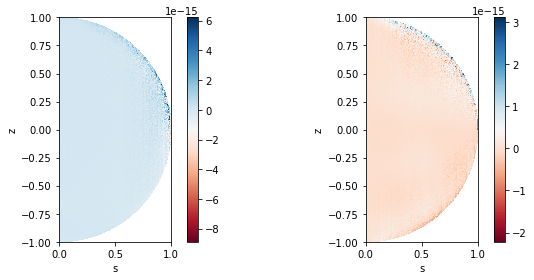

In [10]:
# Radial multiplication
Lmax, Nmax = 10, 6
m, alpha = 1, 0

ns, neta = 256, 255
s = np.linspace(0,1,ns)
t = 2*s**2 - 1
eta = np.linspace(-1,1,neta)
basis = [psi(Nmax, m, ell, s, eta, sigma=0, alpha=alpha) for ell in range(Lmax)]
upbasis = [psi(Nmax+1, m, ell, s, eta, sigma=+1, alpha=alpha+1) for ell in range(Lmax)]
umbasis = [psi(Nmax+2, m, ell, s, eta, sigma=-1, alpha=alpha+1) for ell in range(Lmax)]
uzbasis = [psi(Nmax+2, m, ell, s, eta, sigma= 0, alpha=alpha+1) for ell in range(Lmax+1)]

F = 1/(np.arange(1,Lmax+1).reshape(Lmax,1)*np.arange(1,Nmax+1))
f = expand(basis, F)

s, eta = s.reshape(1,ns), eta.reshape(neta,1)
z = np.sqrt(1-s**2)*eta
us_grid = s * f
uz_grid = z * f

operator = sph.RadialMultiplication()
Rops = operator(m, Lmax, Nmax, alpha)

Fp = (Rops[0] @ F.ravel()).reshape(operator.codomain[0](Lmax,Nmax,0,alpha)[:2])
Fm = (Rops[1] @ F.ravel()).reshape(operator.codomain[1](Lmax,Nmax,0,alpha)[:2])
Fz = (Rops[2] @ F.ravel()).reshape(operator.codomain[2](Lmax,Nmax,0,alpha)[:2])

up = expand(upbasis, Fp)
um = expand(umbasis, Fm)
uz = expand(uzbasis, Fz)
us = 1/np.sqrt(2) * (up + um)

error_s = us_grid - us
error_z = uz_grid - uz
assert np.max(abs(error_s)) < 1e-14
assert np.max(abs(error_z)) < 1e-14

fig, ax = plt.subplots(1,2,figsize=(9,4))
plotfield(s.ravel(), eta.ravel(), error_s, fig, ax[0], stretch=False)
plotfield(s.ravel(), eta.ravel(), error_z, fig, ax[1], stretch=False)

# fig, ax = plt.subplots(1,3,figsize=(13,4))
# ax[0].spy(Rops[0])
# ax[1].spy(Rops[1])
# ax[2].spy(Rops[2])

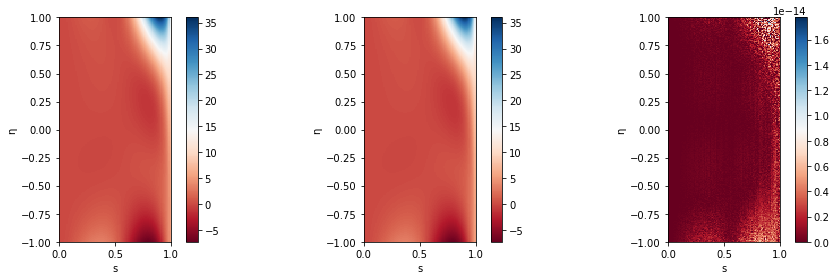

In [11]:
# Spherical radial component e_r . u = 1/2**0.5 *(s u(-) + s u(+)) + eta * (1-s**2)**0.5 * w
Lmax, Nmax, m = 4, 3, 2
ns, neta = 100, 1001
alpha = 1

# Construct the hierarchy of bases.  
# The first index is ell (vertical polynomial degree),
# the second index is k (radial polynomial degree)
s, eta = np.linspace(0,1,ns), np.linspace(-1,1,neta)
upbasis = [psi(Nmax,   m, ell, s, eta, sigma=+1, alpha=alpha) for ell in range(Lmax)]
umbasis = [psi(Nmax,   m, ell, s, eta, sigma=-1, alpha=alpha) for ell in range(Lmax)]
u0basis = [psi(Nmax,   m, ell, s, eta, sigma= 0, alpha=alpha) for ell in range(Lmax)]
cobasis = [psi(Nmax+1, m, ell, s, eta, sigma= 0, alpha=alpha) for ell in range(Lmax+1)]

# Construct the coefficients
# cp = np.ones((Lmax,Nmax))
# cm = np.ones((Lmax,Nmax))
# c0 = np.ones((Lmax,Nmax))
cp = np.random.rand(Lmax,Nmax)
cm = np.random.rand(Lmax,Nmax)
c0 = np.random.rand(Lmax,Nmax)

# Expand the function
up = expand(upbasis, cp)
um = expand(umbasis, cm)
u0 = expand(u0basis, c0)

# Apply the operator in grid space
ss, ee = s.reshape(1,ns), eta.reshape(neta,1)
fgrid = np.sqrt(0.5) * ss * (up + um) + ee * np.sqrt(1-ss**2) * u0

# Coeff space operator
operator = sph.RadialVector()
Op = operator(m, Lmax, Nmax, alpha)

# Apply the operators
c = np.concatenate([cp.ravel(),cm.ravel(),c0.ravel()])
d = (Op @ c).reshape(Lmax+1,Nmax+1)
fcoeff = expand(cobasis, d)

# Compute error
error = fgrid-fcoeff
assert np.max(abs(error)) < 5e-14

# Plot
fig, ax = plt.subplots(1,3,figsize=(13,4))
plotfield(s, eta, fgrid,  fig, ax[0], stretch=True)
plotfield(s, eta, fcoeff, fig, ax[1], stretch=True)
plotfield(s, eta, np.abs(error),  fig, ax[2], stretch=True)

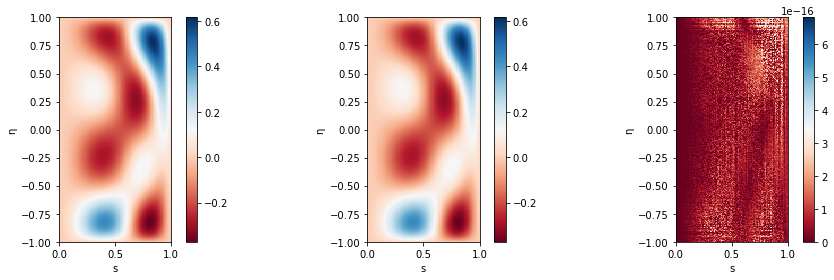

In [23]:
# Multiplication by (1-r**2)
Lmax, Nmax, m = 4, 3, 2
ns, neta = 100, 1001
sigma, alpha = 0, 1

# Construct the hierarchy of bases.  
# The first index is ell (vertical polynomial degree),
# the second index is k (radial polynomial degree)
s, eta = np.linspace(0,1,ns), np.linspace(-1,1,neta)
basis = [psi(Nmax, m, ell, s, eta, sigma=sigma, alpha=alpha) for ell in range(Lmax)]
cobasis = [psi(Nmax+1, m, ell, s, eta, sigma=sigma, alpha=alpha-1) for ell in range(Lmax+2)]
gbasis = [sph.phi(Nmax, m, ell, s, eta, sigma=sigma, alpha=alpha) for ell in range(Lmax)]

# Construct the coefficients
c = np.random.rand(Lmax,Nmax)

# Expand the function
f = expand(basis, c)

# Apply the operator in grid space
ss, ee = s.reshape(1,ns), eta.reshape(neta,1)
fgrid = (1-ee**2)*(1-ss**2) * f

# Coeff space operator
Op = sph.operator('1-r**2')(m, Lmax, Nmax, alpha, sigma)

# Apply the operators
d = (Op @ c.ravel()).reshape(Lmax+2,Nmax+1)
fcoeff = expand(cobasis, d)
fcoeff_phi = expand(gbasis, c)

# Compute error
error = fgrid-fcoeff
error_phi = fgrid-fcoeff_phi
assert np.max(abs(error)) < 2e-15
assert np.max(abs(error_phi)) < 2e-15

# Plot
fig, ax = plt.subplots(1,3,figsize=(13,4))
plotfield(s, eta, fgrid,  fig, ax[0], stretch=True)
plotfield(s, eta, fcoeff, fig, ax[1], stretch=True)
plotfield(s, eta, np.abs(error),  fig, ax[2], stretch=True)

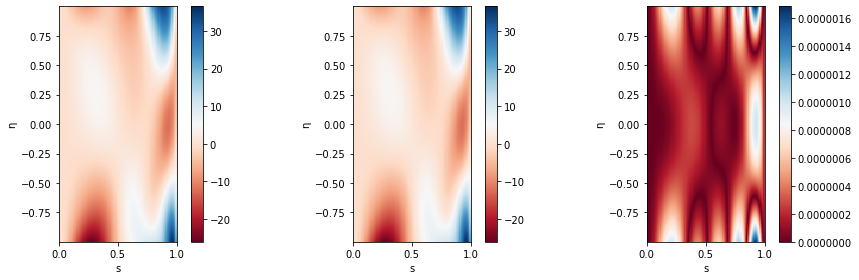

In [13]:
# Test e_z . Grad(psi) the z component of the gradient of a scalar field
Lmax, Nmax, m = 6, 5, 2
ns, neta = 100, 10001

# Construct the hierarchy of bases.  
# The first index is ell (vertical polynomial degree),
# the second index is k (radial polynomial degree)
s, eta = np.linspace(0,1,ns), np.linspace(-1,1,neta)
basis   = [psi(Nmax, m, ell, s, eta, sigma=0, alpha=0) for ell in range(Lmax)]
cobasis = [psi(Nmax, m, ell, s, eta, sigma=0, alpha=1) for ell in range(Lmax-1)]

# Construct the coefficients
c = np.zeros((Lmax,Nmax))
c[0,0] = 1
c[2,2] = 1
c[2,3] = -1
c[3,1] = 1
c[3,3] = .5
c[5,4] = -.1

# Expand the function
f = expand(basis, c)

# Apply the operator in grid space
ss, ee = s.reshape(1,ns), eta.reshape(neta,1)
scale = np.sqrt(1-ss**2)
scale[np.abs(scale) == 0] = 1
fgrid = (f[2:,:]-f[:-2,:])/(ee[2:,:]-ee[:-2,:])/scale

# Apply the operator in coeff space
operator = sph.Gradient()
opz = operator(m, Lmax, Nmax, alpha=0)[2]
d = (opz @ c.ravel()).reshape(operator.codomain[2](Lmax,Nmax,0,0)[:2])
fcoeff = expand(cobasis, d)

# Match sizes and compute error
fcoeff = fcoeff[1:-1,:]
eta = eta[1:-1]
error = fgrid-fcoeff

assert np.max(abs(error)) < 2e-6

# Plot
fig, ax = plt.subplots(1,3,figsize=(13,4))
plotfield(s, eta, fgrid,  fig, ax[0], stretch=True)
plotfield(s, eta, fcoeff, fig, ax[1], stretch=True)
plotfield(s, eta, np.abs(error),  fig, ax[2], stretch=True)


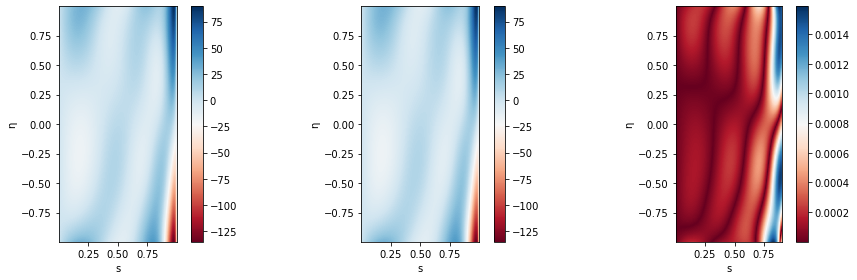

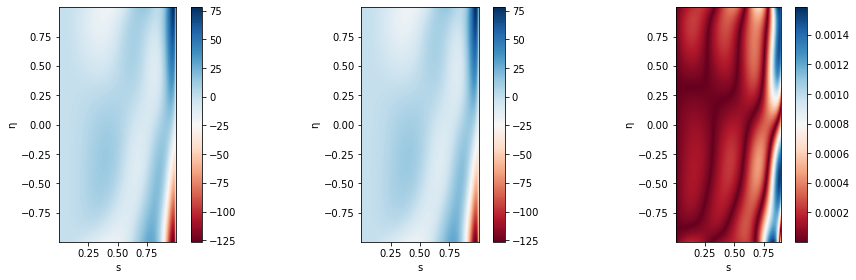

In [14]:
# Test 1/sqrt(2) * (e_s \pm i e_{phi}) . Grad(psi) the u(+) and u(-) components of the gradient of a scalar field
Lmax, Nmax, m = 6, 5, 2
ns, neta = 1001, 1001

# Construct the hierarchy of bases.  
# The first index is ell (vertical polynomial degree),
# the second index is k (radial polynomial degree)
s, eta = np.linspace(0,1,ns), np.linspace(-1,1,neta)
basis   = [psi(Nmax, m, ell, s, eta, sigma=0, alpha=0) for ell in range(Lmax)]
umbasis = [psi(Nmax+1, m, ell, s, eta, sigma=-1, alpha=1) for ell in range(Lmax)]
upbasis = [psi(Nmax, m, ell, s, eta, sigma=+1, alpha=1) for ell in range(Lmax)]

# Construct the coefficients
c = np.zeros((Lmax,Nmax))
c[0,0] = 1
c[1,4] = 1
c[2,0] = 1
c[2,2] = 1
c[2,3] = -1
c[3,3] = .5
c[5,4] = -.1

# Expand the function
f = expand(basis, c)

# Apply the operator in grid space
ss, ee = s.reshape(1,ns), eta.reshape(neta,1)

dfds = (f[:,2:]-f[:,:-2])/(ss[:,2:]-ss[:,:-2])

scale = 1-ss**2
scale[np.abs(scale) < 1e-12] = 1
dfdeta = (ss/scale)*ee[1:-1,:]*(f[2:,:]-f[:-2,:])/(ee[2:,:]-ee[:-2,:])

scale = ss
scale[np.abs(scale) < 1e-12] = 1
dfdphi = (1/scale * 1j * m * f)

fgridm = 1/np.sqrt(2) * (dfds[1:-1,:] + dfdeta[:,1:-1] - 1j*dfdphi[1:-1,1:-1]).real
fgridp = 1/np.sqrt(2) * (dfds[1:-1,:] + dfdeta[:,1:-1] + 1j*dfdphi[1:-1,1:-1]).real

operator = sph.Gradient()
Opp, Opm, Opz = operator(m, Lmax, Nmax, alpha=0)

# Apply the operator to the coefficients
dm = (Opm @ c.ravel()).reshape(Lmax,Nmax+1)
fcoeffm = expand(umbasis, dm)[1:-1,1:-1]

dp = (Opp @ c.ravel()).reshape(Lmax,Nmax)
fcoeffp = expand(upbasis, dp)[1:-1,1:-1]

eta = eta[1:-1]
s = s[1:-1]

errorm = fgridm-fcoeffm
errorp = fgridp-fcoeffp

# Plot
fig, ax = plt.subplots(1,3,figsize=(13,4))
plotfield(s, eta, fgridm,  fig, ax[0], stretch=True)
plotfield(s, eta, fcoeffm, fig, ax[1], stretch=True)
plotfield(s[:-100], eta, np.abs(errorm[:,:-100]),  fig, ax[2], stretch=True)

fig, ax = plt.subplots(1,3,figsize=(13,4))
plotfield(s, eta, fgridp,  fig, ax[0], stretch=True)
plotfield(s, eta, fcoeffp, fig, ax[1], stretch=True)
plotfield(s[:-100], eta, np.abs(errorp[:,:-100]),  fig, ax[2], stretch=True)


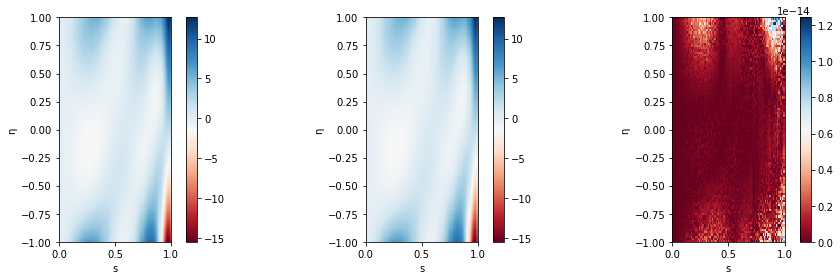

In [15]:
# Conversion operator from alpha -> alpha+1
Lmax, Nmax, m = 6, 5, 2
ns, neta = 101, 101
alpha = 1

# Construct the hierarchy of bases.  
# The first index is ell (vertical polynomial degree),
# the second index is k (radial polynomial degree)
s, eta = np.linspace(0,1,ns), np.linspace(-1,1,neta)
basis   = [psi(Nmax, m, ell, s, eta, sigma=0, alpha=alpha) for ell in range(Lmax)]
cobasis = [psi(Nmax+1, m, ell, s, eta, sigma=0, alpha=alpha+1) for ell in range(Lmax)]

# Construct the coefficients
c = np.zeros((Lmax,Nmax))
c[0,0] = 1
c[1,4] = 1
c[2,0] = 1
c[2,2] = 1
c[2,3] = -1
c[3,3] = .5
c[5,4] = -.1

# Expand the function
fgrid = expand(basis, c)

# Construct the operator
conversion = sph.Conversion()
Op = conversion(m, Lmax, Nmax, alpha=alpha, sigma=0)

# Apply the operator
d = (Op @ c.ravel()).reshape(Lmax,Nmax+1)
fcoeff = expand(cobasis, d)
error = fgrid - fcoeff

assert np.max(np.abs(error)) < 2e-14

# Plot
fig, ax = plt.subplots(1,3,figsize=(13,4))
plotfield(s, eta, fgrid,  fig, ax[0], stretch=True)
plotfield(s, eta, fcoeff, fig, ax[1], stretch=True)
plotfield(s, eta, np.abs(error), fig, ax[2], stretch=True)


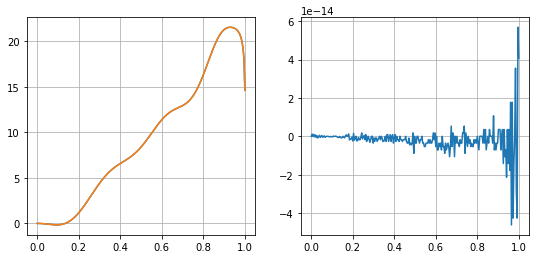

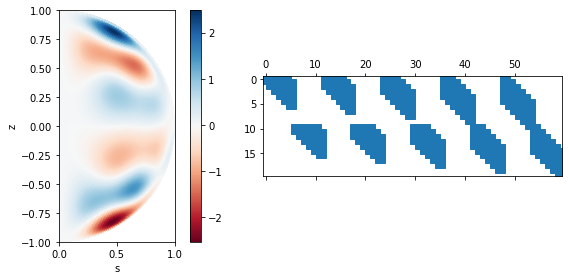

In [16]:
# Boundary evaluation
Lmax, Nmax = 10, 6
m, alpha, sigma = 3, 1, -1

s = np.linspace(0,1,256)
t = 2*s**2 - 1
eta = np.array([1.])
basis = [psi(Nmax, m, ell, s, eta, sigma=sigma, alpha=alpha) for ell in range(Lmax)]

F = 1/(np.arange(1,Lmax+1).reshape(Lmax,1)*np.arange(1,Nmax+1))
f = expand(basis, F).ravel()

# Compute the boundary evaluation operator
Boundary = sph.Boundary()
Opeven, Opodd = Boundary(m, Lmax, Nmax, alpha, sigma, separate=True)

# Apply the boundary evaluation operator and expand
Feven = (Opeven @ F.ravel())
Fodd = (Opodd @ F.ravel())

even_codomain, odd_codomain = Boundary.codomain(m, Lmax, Nmax, alpha, sigma)
cobasis = Jacobi.polynomials(*even_codomain,t).T
feven = cobasis @ Feven

cobasis = Jacobi.polynomials(*odd_codomain,t).T
fodd = cobasis @ Fodd

fcoeff = (1+t)**((m+sigma)/2) * (feven + np.sqrt(1-t) * fodd)
error = f - fcoeff

assert np.max(abs(error)) < 1e-13

# Plot the boundary evaluation
fig, plot_axes = plt.subplots(1,2,figsize=(9,4))
plot_axes[0].plot(s, f)
plot_axes[0].plot(s, fcoeff)
plot_axes[1].plot(s, f - fcoeff)
for ax in plot_axes:
    ax.grid()

# Plot a field in the nullspace of the operator, 
# i.e. a field that vanishes on the sphere boundary
Op = sparse.vstack([Opeven,Opodd])
nullspace = sp.linalg.null_space(Op.todense())

eta = np.linspace(-1,1,256)
basis = [psi(Nmax, m, ell, s, eta, sigma=sigma, alpha=alpha) for ell in range(Lmax)]

which = 10
F = nullspace[:,which].reshape(Lmax,Nmax)
f = expand(basis, F)

fig, ax = plt.subplots(1,2,figsize=(9,4))
plotfield(s, eta, f, fig, ax[0], stretch=False)
ax[1].spy(Op)


In [17]:
# Vector identities: Div(Curl) = 0 and Curl(Grad) = 0
Lmax, Nmax, m = 6, 4, 2
alpha = 1

curlp, curlm, curlz = sph.Curl()(m, Lmax, Nmax, alpha)
curlp = sph.resize(curlp, Lmax, Nmax, Lmax, Nmax+1)
curl = sparse.vstack([curlp,curlm,curlz])
div = sph.Divergence()(m, Lmax, Nmax+1, alpha+1)
dc = div @ curl
assert np.max(np.abs(dc)) < 3e-14

gradp, gradm, gradz = sph.Gradient()(m, Lmax, Nmax, alpha-1)
gradp = sph.resize(gradp, Lmax, Nmax, Lmax, Nmax+1)
gradz = sph.resize(gradz, Lmax-1, Nmax, Lmax, Nmax+1)
grad = sparse.vstack([gradp,gradm,gradz])
curlp, curlm, curlz = sph.Curl()(m, Lmax, Nmax+1, alpha)
curlp = sph.resize(curlp, Lmax, Nmax+1, Lmax, Nmax+2)
curl = sparse.vstack([curlp,curlm,curlz])
cg = curl @ grad
assert np.max(np.abs(cg)) < 4e-14


In [18]:
print('All tests passed')

All tests passed
